# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [1]:
#standard width is ~60%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import norm
import matplotlib as mpl
import yfinance as yf
import math
import json
import datetime as DT
from scipy import optimize

In [3]:
import logging
logger = logging.getLogger('yfinance')
logger.disabled = True
logger.propagate = False

# In this project, we will set up a "high risk" and "low risk" portfolio, it's on us to define these terms   


   
# We start with the least risky:
- The goal here will be to get all stock data from the past two years, sort by volume and cut to 200 stocks, sort by volatility and cut to 100 stocks
- Then, we have developed a search algorithm that should come up with a very low correlated portfolo in a short amount of time
- For demonstration we will pick 10 stocks to create the portfolio, then optimize the weights for minimal variance again
- This should be close to the least risky you can have, and will most likely be profitable. If not profitable, we can incorporate an intermediate step where we sort by log returns

## First, we'll need NASDAQ tickers

In [4]:
absolute_path_to_tickers = '/home/travis/Documents/Reseach/Quant_Prep/Stock_Utilities'
nasdaq_json = absolute_path_to_tickers+'/Nasdaq.json'

with open(nasdaq_json, 'r') as data_file:
    nasdaq_data = data_file.read()

nasdaq_tickers = np.array(json.loads(nasdaq_data))

In [5]:
# DOWNLOAD ALL TICKER DATA FROM LAST 2 YEARS
tickers = [nasdaq_tickers[i]['Symbol'] for i in range(len(nasdaq_tickers))]
start = DT.datetime.today() -  DT.timedelta(days = 2*365)
end = DT.datetime.today() -  DT.timedelta(days = 365)


ALL_ASSETS = yf.download(tickers, start=start, end=end)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4944 of 4944 completed


In [6]:
NA_dropped = ALL_ASSETS.drop(ALL_ASSETS.tail(1).index).dropna(axis=1)
%reset_selective ALL_ASSETS

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Take the first 200, ordered by mean volume. We only care about log returns now.

In [7]:
mean_volume = NA_dropped['Volume'].mean()
# sort will by defaults ascend least to greatest, but we want greatest to least so "ascending=False"
sorted_tickers = mean_volume.sort_values(ascending=False).index

log_returns = np.log(NA_dropped['Close'] / NA_dropped['Close'].shift(1))
volume_sorted_log_returns = log_returns[sorted_tickers[0:200]].dropna()

/home/travis/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


## Now we sort by volatility, averaged over the entire two years. Take the smallest 100

In [8]:
volatility = volume_sorted_log_returns.std()
tickers_by_volatility = volatility.sort_values().index
sorted_volatility = volume_sorted_log_returns[tickers_by_volatility[0:100]]

## Find the Pearson covariance matrix and find its abs(minimum)

In [10]:
COV_MAT = sorted_volatility.cov()
abs_cov = COV_MAT.abs()
# Use idxmin twice to get the location of the minimum
col = abs_cov.min().idxmin()
row = abs_cov[col].idxmin()
min_val = COV_MAT.at[row, col]

print(f"Minimum covariance is between {row} and {col}: {min_val:.4f}")
initial_labels = [row,col]

Minimum covariance is between PDBC and SHY: 0.0000


## Now, we find a chain of covariances which minimize the existing covariances in the chain   
This doesn't necessarily find the minimum, but it should be somewhat close for our purposes

In [11]:
def total_variance_in_quadrature(cov_df, labels):
    """Compute total variance by summing all variances + covariances in quadrature"""
    sub_cov = cov_df.loc[labels, labels]
    total_var = sub_cov.to_numpy().sum()
    return total_var

In [12]:
selected_labels = initial_labels.copy()

while len(selected_labels) < 50:
    remaining_labels = [lbl for lbl in COV_MAT.columns if lbl not in selected_labels]
    best_label = None
    best_var = np.inf

    for candidate in remaining_labels:
        trial_labels = selected_labels + [candidate]
        var = total_variance_in_quadrature(COV_MAT, trial_labels)
        if var < best_var:
            best_var = var
            best_label = candidate

    selected_labels.append(best_label)

final_safe_log_returns = sorted_volatility[selected_labels]
final_COV = final_safe_log_returns.cov()

## With the chain of variances found, we can put our portfolio together to find its conglomerate return and covariance

In [13]:
conglomerate_log_returns = final_safe_log_returns.mean(axis=1)
total_log_returns = round(np.sum(conglomerate_log_returns),6)
print(f"Total Annualized log returns:  {total_log_returns*np.sqrt(252)}%")
n_assets = final_COV.shape[0]
equal_weights = np.array([1/n_assets] * n_assets)
var_vec = np.matmul(equal_weights,final_COV)
total_var = np.dot(equal_weights,var_vec)
print(f"Equally Weighted Anualized Volatility Sum: {np.sqrt(total_var*252)}%")

Total Annualized log returns:  1.4297851745097934%
Equally Weighted Anualized Volatility Sum: 0.07856155668172658%


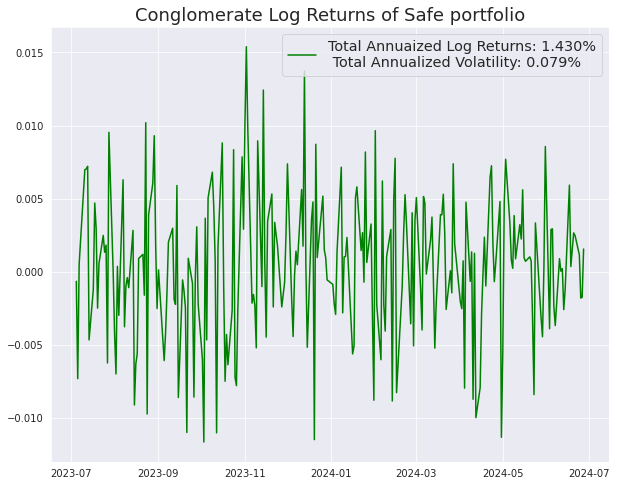

In [14]:
fig,ax = plt.subplots(figsize=(10,8))
c = "g" if total_log_returns > 0 else "r" if total_log_returns < 0 else "k"

ax.plot(conglomerate_log_returns,color=c,label="Total Annuaized Log Returns: {:.3f}%\n Total Annualized Volatility: {:.3f}%".format(total_log_returns*np.sqrt(252),np.sqrt(total_var*252)))
ax.legend(fontsize='x-large')
ax.set_title(r"Conglomerate Log Returns of Safe portfolio",size=18)
plt.show()

In [15]:
assets = list(final_safe_log_returns.columns.values)
print("ASSETS IN SAFE PORTFOLIO ARE: ", assets)

ASSETS IN SAFE PORTFOLIO ARE:  ['PDBC', 'SHY', 'VCSH', 'IGSB', 'BNDX', 'QYLD', 'BND', 'TMUS', 'VCIT', 'IBKR', 'IEF', 'PEP', 'ARCC', 'PFF', 'FAST', 'EMB', 'KDP', 'CSCO', 'MSFT', 'KHC', 'ORLY', 'PAA', 'AZN', 'CTSH', 'AAPL', 'FOXA', 'MDLZ', 'TLT', 'ACWI', 'CSX', 'GILD', 'BKR', 'NFLX', 'XEL', 'CMCSA', 'QQQ', 'EXC', 'WDC', 'VOD', 'MNST', 'VTRS', 'SBUX', 'TSCO', 'DBX', 'AEP', 'NVDA', 'APA', 'DXCM', 'GRAB', 'MCHI']


## Not a very good portfolio, doesn't beat the risk free rate

# Now moving on to the risky protfolio

## Here, we'll take a slightly different strategy since we stand to take on extra risk, we will stand to make more return. However, we don't wan't to expose ourselves to too much risk. Therefore, we will again sort by Volume, and then sort by RETURN. Then, we will find the weights which maximize the Sharpe Ratio.

In [16]:
N = 100

In [17]:
# we already have volume_sorted_log_returns
mean_returns = volume_sorted_log_returns.mean(axis=0)
tickers_by_return = mean_returns.sort_values(ascending=False).index
sorted_returns = volume_sorted_log_returns[tickers_by_return[0:N]]
mean_returns_cut = sorted_returns.mean(axis=0)
COV_mat = sorted_returns.cov()

In [18]:
mean_returns_cut

Ticker
NVDL    0.006895
MSTR    0.005627
SMCI    0.005135
CLSK    0.004809
VKTX    0.004800
          ...   
VCSH    0.000234
CTSH    0.000198
BNDX    0.000187
SHY     0.000174
BND     0.000132
Length: 100, dtype: float64

In [19]:
COV_mat

Ticker,NVDL,MSTR,SMCI,CLSK,VKTX,APP,NVDA,DJT,COIN,CRWD,...,PFF,PDBC,ARQT,IGSB,VCIT,VCSH,CTSH,BNDX,SHY,BND
Ticker,,,,,,,,,,,,,,,,,,,,,
NVDL,0.002610,0.000681,0.001761,0.000663,0.000199,0.000495,0.001427,-0.000073,0.000731,0.000610,...,0.000043,6.186261e-06,0.000070,0.000010,0.000025,0.000009,0.000063,0.000017,0.000003,0.000017
MSTR,0.000681,0.003252,0.000866,0.002243,0.000960,0.000259,0.000363,0.000375,0.001823,0.000406,...,0.000069,4.619970e-05,0.000469,0.000009,0.000031,0.000010,0.000054,0.000016,0.000003,0.000024
SMCI,0.001761,0.000866,0.003486,0.000878,0.000338,0.000501,0.000982,0.000317,0.000682,0.000533,...,0.000062,3.115249e-05,0.000558,0.000015,0.000038,0.000013,0.000165,0.000024,0.000006,0.000030
CLSK,0.000663,0.002243,0.000878,0.004937,0.001068,0.000673,0.000373,0.000567,0.002197,0.000469,...,0.000125,6.714251e-05,0.001318,0.000027,0.000068,0.000025,0.000099,0.000038,0.000015,0.000059
VKTX,0.000199,0.000960,0.000338,0.001068,0.004981,0.000260,0.000113,0.000540,0.000706,0.000290,...,0.000030,1.720261e-05,0.001052,0.000008,0.000019,0.000008,0.000024,0.000010,0.000003,0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VCSH,0.000009,0.000010,0.000013,0.000025,0.000008,0.000010,0.000006,0.000007,0.000019,0.000006,...,0.000007,2.804926e-07,0.000019,0.000003,0.000007,0.000003,0.000006,0.000004,0.000002,0.000007
CTSH,0.000063,0.000054,0.000165,0.000099,0.000024,0.000075,0.000043,0.000072,0.000083,0.000074,...,0.000021,7.888970e-06,0.000095,0.000006,0.000015,0.000006,0.000162,0.000008,0.000004,0.000012
BNDX,0.000017,0.000016,0.000024,0.000038,0.000010,0.000011,0.000010,0.000004,0.000028,0.000010,...,0.000011,-1.024875e-06,0.000022,0.000004,0.000011,0.000004,0.000008,0.000009,0.000003,0.000011


## According to the website below, the bond rate over the past 2 years is about 3.7%
https://ycharts.com/indicators/2_year_treasury_rate
## We'll need this for the Sharpe ratio

In [20]:
def SharpeRatio(weight_vec,mu_vec,Cov_mat,r=0.037):
    mu_tot = np.dot(mu_vec,weight_vec)
    Cov_tot = np.matmul(Cov_mat,weight_vec)
    Cov_tot = np.matmul(weight_vec,Cov_tot)
    return (mu_tot - r)/Cov_tot

## Optimize sharpe ratio under constraints, e.g. we don't want to put more than 35% of our capital into a stock. Let's also only invest, no shorting or negative contributions

In [21]:
n_assets = COV_mat.shape[0]
initial_weights = np.array([1/n_assets] * n_assets)
assets = sorted_returns.columns.values

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)},
              {'type': 'ineq', 'fun': lambda weights: -weights})

result = optimize.minimize(SharpeRatio, initial_weights, constraints = constraints, args = (mean_returns_cut.values,COV_mat.values))
optimal_weights = result.x

print("Optimal Asset Weights to minimize variance:")
for asset, weight in zip(assets, optimal_weights):
    print(f"{asset}: Weight = {weight:.4f}")

Optimal Asset Weights to minimize variance:
NVDL: Weight = 0.0099
MSTR: Weight = 0.0099
SMCI: Weight = 0.0099
CLSK: Weight = 0.0098
VKTX: Weight = 0.0099
APP: Weight = 0.0100
NVDA: Weight = 0.0100
DJT: Weight = 0.0100
COIN: Weight = 0.0099
CRWD: Weight = 0.0100
OCGN: Weight = 0.0099
ASTS: Weight = 0.0099
IBRX: Weight = 0.0099
FEMY: Weight = 0.0100
WULF: Weight = 0.0098
HOOD: Weight = 0.0100
IREN: Weight = 0.0098
MU: Weight = 0.0100
WDC: Weight = 0.0100
ARDX: Weight = 0.0099
AFRM: Weight = 0.0099
PDD: Weight = 0.0100
ALT: Weight = 0.0099
TQQQ: Weight = 0.0099
AVGO: Weight = 0.0100
META: Weight = 0.0100
NVAX: Weight = 0.0099
SMH: Weight = 0.0100
QCOM: Weight = 0.0100
LRCX: Weight = 0.0100
CCCC: Weight = 0.0099
ESPR: Weight = 0.0099
PLTR: Weight = 0.0099
AMAT: Weight = 0.0100
BITF: Weight = 0.0099
GOOG: Weight = 0.0100
NFLX: Weight = 0.0100
GOOGL: Weight = 0.0100
AMZN: Weight = 0.0100
IBKR: Weight = 0.0101
CLOV: Weight = 0.0100
DKNG: Weight = 0.0100
FLEX: Weight = 0.0100
DASH: Weight = 0.

## So what do the returns of this portfolio look like?

In [22]:
Risky_Portfolo = sorted_returns * optimal_weights

conglomerate_log_returns = Risky_Portfolo.mean(axis=1)
total_log_returns = round(np.sum(conglomerate_log_returns),6)
print(f"Total Annualized log returns:  {total_log_returns*np.sqrt(252)}%")
total_var = np.matmul(COV_mat,optimal_weights)
total_var = np.matmul(optimal_weights,total_var)
print(f"Equally Weighted Anualized Volatility Sum: {np.sqrt(total_var*252)}%")

Total Annualized log returns:  0.06483149012632673%
Equally Weighted Anualized Volatility Sum: 0.21656660852556156%


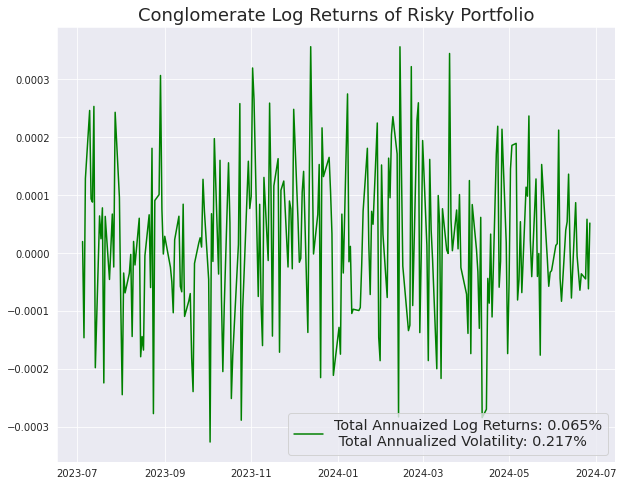

In [23]:
fig,ax = plt.subplots(figsize=(10,8))
c = "g" if total_log_returns > 0 else "r" if total_log_returns < 0 else "k"

ax.plot(conglomerate_log_returns,color=c,label="Total Annuaized Log Returns: {:.3f}%\n Total Annualized Volatility: {:.3f}%".format(total_log_returns*np.sqrt(252),np.sqrt(total_var*252)))
ax.legend(fontsize='x-large')
ax.set_title(r"Conglomerate Log Returns of Risky Portfolio",size=18)
plt.show()

## Definitely more volatile, but even worse with returns! 